<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Use-gurobi-with-guesses-about-AR" data-toc-modified-id="Use-gurobi-with-guesses-about-AR-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Use gurobi with guesses about AR</a></span></li><li><span><a href="#Quantum-time-estimation" data-toc-modified-id="Quantum-time-estimation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Quantum time estimation</a></span><ul class="toc-item"><li><span><a href="#Constants" data-toc-modified-id="Constants-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Constants</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Classical-times" data-toc-modified-id="Classical-times-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Classical times</a></span><ul class="toc-item"><li><span><a href="#Helper-classes-and-functions" data-toc-modified-id="Helper-classes-and-functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Helper classes and functions</a></span></li></ul></li><li><span><a href="#Plot" data-toc-modified-id="Plot-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot</a></span></li><li><span><a href="#Gurobi-modeling" data-toc-modified-id="Gurobi-modeling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Gurobi modeling</a></span><ul class="toc-item"><li><span><a href="#Gurobi-activate" data-toc-modified-id="Gurobi-activate-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Gurobi activate</a></span></li></ul></li><li><span><a href="#Old-scripts-by-Tom" data-toc-modified-id="Old-scripts-by-Tom-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Old scripts by Tom</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cartesian_explorer import Explorer
import cartesian_explorer as caex

In [3]:
cache = caex.caches.JobLibCache("../data/caex_cache/energy_eff")
ex = Explorer(cache=cache)

## Use gurobi with guesses about AR




* $UB$ - upper bound on maxcut cost
* $LB$ - lower bound 
* $C$ - optimal cost
$UB>C$


$AR = \frac{LB}{C} > \frac{LB}{UB}$

In [4]:
import networkx as nx
from typing import Tuple
import gurobipy as gb
import time

In [5]:
def maxcut_bounds_history(G: nx.Graph,
                          max_time=10*60,
                          max_cost=None,
                          timedelta=3,
                          max_ar=1.0
                         ) -> Tuple[list, list]:
    p = gb.Model()
    p.setParam('TimeLimit', timedelta)
    if max_cost is not None:
        p.setParam('BestObjStop', max_cost)
    vdict = {}
    for n in G.nodes:
        vdict[n] = p.addVar(name='v_'+str(n), vtype=gb.GRB.BINARY)
    scaled_v = {v:(2*x - 1) for v, x in vdict.items()}
    C_i = [vdict[i] + vdict[j] - 2*vdict[i]*vdict[j] for i, j in G.edges]
    
    p.setObjective(sum(C_i), gb.GRB.MAXIMIZE)
    
    start = time.time()
    upper = []
    lower = []
    while time.time() - start < max_time:
        p.optimize()
        upper.append(p.ObjBound)
        lower.append(p.ObjVal)
        if upper[-1] == lower[-1]:
            print('Found an optimal solution!')
            break
        if lower[-1]/upper[-1] > max_ar:
            print('Found a good enough AR')
            break
            
        
    return upper, lower



## Quantum time estimation

### Constants

In [6]:
ms = 1e-3
us = 1e-6

#times
mot_load_time = 200*ms
rearrange_per_move_time = 10*ms
rearrange_per_move_time_fast = 2*ms
occupation_measurement_time = 10*ms
occupation_measurement_time_fast = 1*ms
destructive_state_measurement_time = 10*ms
nondestructive_state_measurement_time = 2*ms
nondestructive_state_measurement_time_fast = 0.5*ms
state_prep_time = 0.1*ms
microwave_rx_time = 25*us
cz_time = 1*us
cz_time_fast = 0.2*us
rz_time = 0.5*us
raman_rx_time = 1*us

In [7]:
#losses
rearrange_per_move_loss = 0.01
occupation_measurement_loss = 0.001
nondestructive_state_measurement_loss = 0.01
atom_lifetime_short = 30
atom_lifetime_long = 100
atom_lifetime_cryogenic = 1000

### Functions

In [8]:
def background_loss_per_atom_short(time):
    return 1-np.exp(-time/atom_lifetime_short)

def background_loss_per_atom_long(time):
    return 1-np.exp(-time/atom_lifetime_long)

def background_loss_per_atom_cryogenic(time):
    return 1-np.exp(-time/atom_lifetime_cryogenic)

def qaoa_lhz_time_sequential_simple(n, p, d):
    n_atoms = np.ceil(n*d/2)
    n_cz_gates = n_atoms*6*p # upper bound in LHZ encoding of MAXCUT
    n_local_rx_gates = 2*n_cz_gates # probably overestimate also since some gates cancel, but there are nominally rotations before and after every cz gate to turn into cnot
    n_local_rz_gates = n_cz_gates
    n_global_single_qubit_gates = p+1
    return n_cz_gates*cz_time + n_local_rz_gates*rz_time + n_local_rx_gates*microwave_rx_time + n_global_single_qubit_gates*microwave_rx_time

def qaoa_lhz_time_sequential_raman_1q_simple(n, p, d):
    n_atoms = np.ceil(n*d/2)
    n_cz_gates = n_atoms*6*p # upper bound in LHZ encoding of MAXCUT
    n_local_rx_gates = 2*n_cz_gates # probably overestimate also since some gates cancel, but there are nominally rotations before and after every cz gate to turn into cnot
    n_local_rz_gates = n_cz_gates
    n_global_single_qubit_gates = p+1
    return n_cz_gates*cz_time + n_local_rz_gates*rz_time + n_local_rx_gates*raman_rx_time + n_global_single_qubit_gates*microwave_rx_time

def qaoa_lhz_time_parallel_simple(n, p, d):
    n_atoms = np.ceil(n*d/2)
    n_cz_gates = n_atoms*p # upper bound in LHZ encoding of MAXCUT, reduced by average 6 in parallel?
    n_local_rx_gates = 2*p # probably overestimate also since some gates cancel, but there are nominally rotations before and after every cz gate to turn into cnot
    n_local_rz_gates = n_cz_gates
    n_global_single_qubit_gates = p+1
    return n_cz_gates*cz_time + n_local_rz_gates*rz_time + n_local_rx_gates*raman_rx_time + n_global_single_qubit_gates*microwave_rx_time

In [9]:
req = ('N', 'p', 'd', 'n_samples')

In [10]:
@ex.add_function(provides=('qaoa_time_destructive_sequential'), requires=req)
def sample_rate_destructive_sequential_really_simple(N, p, d, n_samples):
    # :param n_qaoa: number of nodes in the QAOA graph
    # :param p_qaoa: depth of QAOA operation
    # :param d_qaoa: average degree of graph

    n_qaoa, p_qaoa, d_qaoa = N, p, d
    n_atoms = np.ceil(n_qaoa*d_qaoa/2) #overhead from LHZ encoding
    n_rearranger_moves = n_atoms #probably overestimate, but not by a lot, could replace with average from Hungarian
    rearrange_time = rearrange_per_move_time*n_rearranger_moves
    n_occupancy_pictures_average = 3 #picture after loading to seed rearrange, picture after rearrange finding small defect number remaining, picture verifying final defect removal, could reduce to 2
    taking_pictures_time = n_occupancy_pictures_average*occupation_measurement_time + destructive_state_measurement_time
    overhead_time = mot_load_time + rearrange_time + taking_pictures_time + state_prep_time
    qaoa_time = qaoa_lhz_time_sequential_simple(n_qaoa, p_qaoa, d_qaoa)
    sample_time = overhead_time + qaoa_time
    return sample_time*n_samples

In [11]:
@ex.add_function(provides=('qaoa_time_nondestructive_sequential'), requires=req)
def sample_rate_nondestructive_sequential_really_simple(N, p, d, n_samples):
    # assume have reservoir of size 0.25*n_atoms, implying full array of size 2.5*n_atoms with 0.5 loading
    n_qaoa, p_qaoa, d_qaoa = N, p, d
    n_atoms = np.ceil(n_qaoa*d_qaoa/2)
    n_rearranger_moves = n_atoms
    rearrange_time = n_rearranger_moves*rearrange_per_move_time
    overhead_time = mot_load_time + rearrange_time + 2*occupation_measurement_time
    initialization_losses = n_rearranger_moves*rearrange_per_move_loss + \
                            n_atoms*background_loss_per_atom_short(n_rearranger_moves*rearrange_per_move_time)

    per_cycle_rearranger_moves = (n_atoms*nondestructive_state_measurement_loss)*np.sqrt(n_atoms)/2
    per_cycle_time = per_cycle_rearranger_moves*rearrange_per_move_time + state_prep_time + \
        qaoa_lhz_time_sequential_simple(n_qaoa, p_qaoa, d_qaoa) + 2*occupation_measurement_time + \
                     nondestructive_state_measurement_time
    per_cycle_losses = n_atoms*occupation_measurement_loss + n_atoms*nondestructive_state_measurement_loss + \
        n_atoms*background_loss_per_atom_short(per_cycle_time) + per_cycle_rearranger_moves*rearrange_per_move_loss

    cycles_per_load = np.maximum(1, np.floor((0.25*n_atoms - initialization_losses)/per_cycle_losses))

    per_load_time = overhead_time + cycles_per_load*per_cycle_time
    sample_rate = cycles_per_load/per_load_time
    return 1/sample_rate*n_samples

@ex.add_function(provides=('qaoa_time_nondestructive_parallel'), requires=req)
def sample_rate_nondestructive_parallel_really_simple(N, p, d, n_samples):
    # assume have reservoir of size 0.25*n_atoms, implying full array of size 2.5*n_atoms with 0.5 loading
    n_qaoa, p_qaoa, d_qaoa = N, p, d
    n_atoms = np.ceil(n_qaoa*d_qaoa/2)
    n_rearranger_moves = np.ceil(np.sqrt(n_atoms))
    rearrange_time = n_rearranger_moves*rearrange_per_move_time
    overhead_time = mot_load_time + rearrange_time + 2*occupation_measurement_time
    initialization_losses = n_atoms*rearrange_per_move_loss + \
                            n_atoms*background_loss_per_atom_short(n_rearranger_moves*rearrange_per_move_time)

    per_cycle_rearranger_moves = n_atoms*nondestructive_state_measurement_loss
    per_cycle_time = per_cycle_rearranger_moves*rearrange_per_move_time + state_prep_time + \
        qaoa_lhz_time_sequential_raman_1q_simple(n_qaoa, p_qaoa, d_qaoa) + 2*occupation_measurement_time + \
                     nondestructive_state_measurement_time
    per_cycle_losses = n_atoms*occupation_measurement_loss + n_atoms*nondestructive_state_measurement_loss + \
        n_atoms*background_loss_per_atom_short(per_cycle_time)

    cycles_per_load = np.maximum(1, np.floor((0.25*n_atoms - initialization_losses)/per_cycle_losses))

    per_load_time = overhead_time + cycles_per_load*per_cycle_time
    sample_rate = cycles_per_load/per_load_time
    return 1/sample_rate

In [12]:
@ex.add_function(provides=('qaoa_time_transport'), requires=req)
def sample_rate_transport_really_simple(N, p, d, n_samples):
    n_qaoa, p_qaoa, d_qaoa = N, p, d
    # overhead from mot load reduced to zero, must only consider average number of losses and corresponding replacement time
    # fully parallel rearrangement only requires single move
    n_atoms = np.ceil(n_qaoa*d_qaoa/2)
    cycle_time = rearrange_per_move_time_fast + state_prep_time + \
        qaoa_lhz_time_parallel_simple(n_qaoa, p_qaoa, d_qaoa) + 2*occupation_measurement_time_fast + \
                     nondestructive_state_measurement_time_fast

    return cycle_time*n_samples

## Classical times

In [13]:
import qtensor
import time

In [14]:
@ex.provider
def graph(N, seed=10):
    return qtensor.toolbox.random_graph(nodes=N, seed=seed, degree=3)

@ex.add_function(provides=('classical_time_gurobi', 'opt_cost'), requires=('graph', ))
def classical_time_gurobi(graph):
    start = time.time()
    c, sol = qtensor.tools.maxcut.gurobi_maxcut(graph, max_time=10*60)
    return time.time() - start, c
    
@ex.provider
def classical_time_gw(graph):
    start = time.time()
    c = qtensor.tools.maxcut.goemans_williamson.gw_cost(graph)
    return time.time() - start
    

In [15]:
@ex.provider
def classical_time_match_cost(graph, approx_ratio):
    start = time.time()
    upper, lower = maxcut_bounds_history(graph, max_ar=approx_ratio)
    return time.time() - start
    

### Helper classes and functions

In [16]:
def log_linear_fit(x, y, x_ext):
    a = np.polyfit(x, np.log(y), deg=1)
    F = np.poly1d(a)
    ln = F(x_ext)
    return np.exp(ln)

def linear_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=1)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

def cubic_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=3)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

def octa_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=6)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

In [17]:
from dataclasses import dataclass

@dataclass
class Line:
    x: np.array 
    y: np.array
        
    def average_flat(self):
        if len(self.y.shape)>1:
            self.std = np.nanstd(self.y, -1)
            self.y = np.nanmean(self.y, -1)
            
@dataclass
class LineFit(Line):
    def log_linear_fit(self, x_ext):
        self.fit_x = x_ext
        self.average_flat()
        self.fit = log_linear_fit(self.x, self.y, self.fit_x)
        return self.fit
    
    def cubic_fit(self, x_ext):
        self.fit_x = x_ext
        self.average_flat()
        self.fit = cubic_fit(self.x, self.y, self.fit_x)
        return self.fit

In [18]:
def get_classical_data(p=30, approx_ratio=0.937
                  , match_max_N=1150, opt_max_N=310
                  , gw_max_N=160
                  , max_N = 3000
                       , seeds = [10, 11]
                 ):
    x_ext = np.array(range(10, max_N, 36))

    x_opt = np.array(range(10, opt_max_N, 16))
    opt_time = ex.map_variable(('classical_time_gurobi')
                                 , N=x_opt
                               ,seed=seeds
                     )
    
    opt_ext = np.arange(10, 400, 16)
    opt = LineFit(x=x_opt, y=opt_time)
    opt.log_linear_fit(opt_ext)
    
    match_ext = np.arange(10, 3200, 32*4)
    #match_ext = np.concatenate((match_ext, np.array([30000])))
    match_time = ex.map_variable(('classical_time_match_cost')
                     , N=match_ext
                                 ,approx_ratio=[approx_ratio]
                                 , seed=seeds
                     )
    match = Line(x=match_ext, y=match_time)

    
    x_gw = np.array(range(10, gw_max_N, 18))
    gw_time = ex.map_variable(('classical_time_gw')
                     , N=x_gw
                     )
    x_ext = np.arange(10, 3400, 12)
    gw_fit = cubic_fit(x_gw, gw_time, x_ext)
    gw = LineFit(x=x_gw, y=gw_time)
    gw.cubic_fit(x_ext)
    return gw, opt, match

def get_quantum_data(p=30
                     , var_name='qaoa_time_transport'
                     , max_N = 3000
                     , d=3
                     , n_samples=1e3
                 ):

    x_ext = np.array(range(10, max_N, 36))
    qaoa_times = ex.map_variable(var_name
                                 , N=x_ext
                                 , p=[p]
                                 , d=[d]
                                 , n_samples=[n_samples]
                     )
    qaoa = Line(x=x_ext, y=qaoa_times)
    return qaoa

## Plot

In [19]:
ex.use_svg()

In [20]:
def plot_advantage(p=6, n_samples=1e3):
    fig = plt.figure(figsize=(8, 4))

    try:
        AR = qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val']
    except KeyError:
        AR = 1 - (0.3-np.log2(p)*0.05)
    gw, opt, match = get_classical_data(p=p, approx_ratio=AR
                                        , max_N=18500
                                        , opt_max_N=350
                                        , gw_max_N=160
                                        ,seeds=[10, 11, 12]
                                        )

    qaoa_transport = get_quantum_data(p=p, var_name='qaoa_time_transport',
                                      max_N=10000, n_samples=n_samples)
    qaoa_dst_seq = get_quantum_data(p=p, var_name='qaoa_time_destructive_sequential',
                                    max_N=10000, n_samples=n_samples)

    plt.yscale('log')
    plt.xscale('log')

    plt.plot(qaoa_transport.x, qaoa_transport.y, color='red',
             label=f'QAOA w/ transport time (quality={np.round(AR, 3)})')
    plt.plot(qaoa_dst_seq.x, qaoa_dst_seq.y, color='orange',
             label=f'QAOA w/ destructive sequential time (quality={np.round(AR, 3)})')
    plt.plot(gw.x, gw.y, '*-', color='green', label='Goemans-Williamson (quality=0.878)')
    plt.plot(opt.x, opt.y, '*-', color='blue', label='Gurobi: optimal (quality=1.0)')
    if hasattr(opt, 'std'):
        plt.fill_between(opt.x, opt.y+opt.std, opt.y-opt.std,
                         color='blue', alpha=0.15 )
    match.average_flat()
    plt.plot(match.x, match.y, '*-', color='magenta',
             label=f'Gurobi: optimal (quality={np.round(AR, 3)})')
    if hasattr(match, 'std'):
        plt.fill_between(match.x, match.y+match.std, match.y-match.std,
                         color='magenta', alpha=0.15 )
    plt.plot(opt.fit_x, opt.fit, '--', color='black', label='log-linear fit')
    plt.plot(gw.fit_x, gw.fit, '--', color='black')
    plt.legend(loc='upper left')
    plt.ylabel('Time to solution')
    plt.title(f'p={p}, n_samples={int(n_samples)}')
    plt.grid()

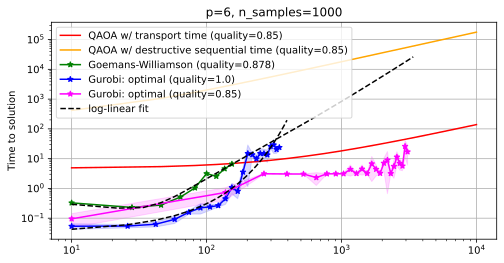

In [22]:
plot_advantage(p=6)
plt.savefig("./plots/p6_time_vs_n.pdf")

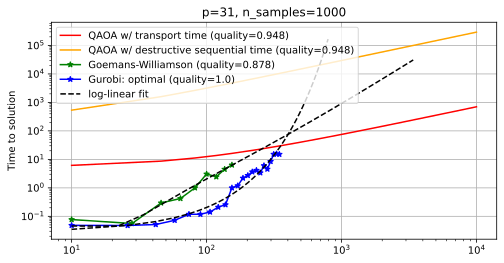

In [24]:
    plot_advantage(p=31)

## Gurobi modeling

In [20]:
import tqdm.auto as tqdm

In [41]:
SEEDS = range(1, 15)

In [ ]:
updata = []
ldata = []
for seed in tqdm.tqdm(SEEDS):
    G = nx.random_regular_graph(3, 250, seed=seed)
    upper, lower = maxcut_bounds_history(G, max_time=45, timedelta=1)
    updata.append(upper)
    ldata.append(lower)

Changed value of parameter TimeLimit to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0xa671ae8a
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve time: 0.00s
Presolved: 375 rows, 625 columns, 1125 nonzeros
Variable types: 0 continuous, 625 integer (625 binary)

Root relaxation: objective -3.750000e+02, 254 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

   808   391  350.66667    7  299  342.00000  354.20000  3.57%   103    7s

Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 91

Explored 843 nodes (88103 simplex iterations) in 1.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 6: 342 341 338 ... -0

Time limit reached
Best objective 3.420000000000e+02, best bound 3.540000000000e+02, gap 3.5088%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0xa671ae8a
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bou

  Gomory: 4
  MIR: 1
  Zero half: 94

Explored 2690 nodes (279743 simplex iterations) in 1.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 343 342 341 ... -0

Time limit reached
Best objective 3.430000000000e+02, best bound 3.520000000000e+02, gap 2.6239%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0xa671ae8a
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  2690   956  345.14286   13  286  343.00000  352.00000  2.62%   104   17s

Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 97


Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  4553  1375     cutoff   14       343.00000  350.83333  2.28%   102   26s

Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 97

Explored 4833 nodes (491284 simplex iterations) in 1.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 343 342 341 ... -0

Time limit reached
Best objective 3.430000000000e+02, best bound 3.500000000000e+02, gap 2.0408%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0xa671ae8a
Model has 375 quadratic objective ter


Explored 6894 nodes (689371 simplex iterations) in 1.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 343 342 341 ... -0

Time limit reached
Best objective 3.430000000000e+02, best bound 3.490000000000e+02, gap 1.7493%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0xa671ae8a
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  6894  1767  345.63636   12  297  343.00000  349.92806  2.02%   100   35s

Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 97

Explored 7202 nodes (719463 simplex 

Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  9549  2039  346.17333   12  297  343.00000  349.30714  1.84%  98.1   44s

Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 97

Explored 9880 nodes (969294 simplex iterations) in 1.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 343 342 341 ... -0

Time limit reached
Best objective 3.430000000000e+02, best bound 3.490000000000e+02, gap 1.7493%
Changed value of parameter TimeLimit to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprin


Solution count 6: 340 339 335 ... -0

Time limit reached
Best objective 3.400000000000e+02, best bound 3.550000000000e+02, gap 4.4118%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x68776f03
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  1173   735  347.50000   26  244  340.00000  355.83333  4.66%  59.3    7s
* 1302   704              37     341.0000000  355.83333  4.35%  60.6    8s

Cutting planes:
  Gomory: 5
  MIR: 2
  Zero half: 71

Explored 1313 nodes (80550 simplex iterations) in 1.05 seconds
Thread cou

Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x68776f03
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  3754  1156  346.00000   25  267  342.00000  352.00000  2.92%  77.0   16s

Cutting planes:
  Gomory: 5
  MIR: 2
  Zero half: 72

Explored 3764 nodes (291026 simplex iterations) in 1.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 8: 342 341 340 ... -0

Time limit reached
Best objective 3.420000000000e+02, best bound 3.520000000000e+02, gap 2.9240%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 col


Continuing optimization...

  6242  1857  346.50000   25  254  342.00000  350.75000  2.56%  76.8   24s
  6528  1911  344.00000   27  262  342.00000  350.50000  2.49%  76.8   25s

Cutting planes:
  Gomory: 5
  MIR: 2
  Zero half: 72

Explored 6705 nodes (514911 simplex iterations) in 1.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 8: 342 341 340 ... -0

Time limit reached
Best objective 3.420000000000e+02, best bound 3.500000000000e+02, gap 2.3392%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x68776f03
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved:

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x68776f03
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  9874  2231     cutoff   30       343.00000  349.50000  1.90%  74.2   34s

Cutting planes:
  Gomory: 5
  MIR: 2
  Zero half: 72

Explored 10405 nodes (769311 simplex iterations) in 1.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 9: 343 342 341 ... -0

Time limit reached
Best objective 3.430000000000e+02, best bound 3.490000000000e+02, gap 1.7493%
Gurobi Optimizer version 9.1.2 build

Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

 13392  2367     cutoff   30       343.00000  349.00000  1.75%  72.5   43s

Cutting planes:
  Gomory: 5
  MIR: 2
  Zero half: 72

Explored 13956 nodes (1008904 simplex iterations) in 1.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 9: 343 342 341 ... -0

Time limit reached
Best objective 3.430000000000e+02, best bound 3.490000000000e+02, gap 1.7493%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x68776f03
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1

Thread count was 8 (of 8 available processors)

Solution count 10: 344 342 341 ... 312

Time limit reached
Best objective 3.440000000000e+02, best bound 3.560000000000e+02, gap 3.4884%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x39ace8a8
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  1066   651  356.23810   15  274  344.00000  356.23810  3.56%  68.1    7s

Cutting planes:
  Gomory: 3
  MIR: 1
  Zero half: 49

Explored 1068 nodes (74025 simplex iterations) in 1.03 seconds
Thread count was 8 (of 8 available p

Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  2576   551  348.13514   23  288  344.00000  351.92857  2.30%  80.5   15s

Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 54

Explored 2893 nodes (242369 simplex iterations) in 1.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 344 342 341 ... 312

Time limit reached
Best objective 3.440000000000e+02, best bound 3.510000000000e+02, gap 2.0349%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x39ace8a8
Model has 375 quadratic objective t


Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 63

Explored 5262 nodes (483322 simplex iterations) in 1.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 344 342 341 ... 312

Time limit reached
Best objective 3.440000000000e+02, best bound 3.490000000000e+02, gap 1.4535%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x39ace8a8
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  5262   652  345.43750   25  280  344.00000  349.10870  1.49%  91.6   25s

Cutting planes:
  Gomory: 4
  MIR:

Model fingerprint: 0x39ace8a8
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  7515   525  346.90361   24  296  344.00000  348.02500  1.17%  93.7   33s

Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 63

Explored 7870 nodes (736737 simplex iterations) in 1.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 344 342 341 ... 312

Time limit reached
Best objective 3.440000000000e+02, best bound 3.470000000000e+02, gap 0.8721%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x39ace8a8
Model

Presolve time: 0.00s
Presolved: 375 rows, 625 columns, 1125 nonzeros
Variable types: 0 continuous, 625 integer (625 binary)

Root relaxation: objective -3.750000e+02, 261 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  375.00000    0  250   -0.00000  375.00000      -     -    0s
H    0     0                     319.0000000  375.00000  17.6%     -    0s
     0     0  362.75000    0  265  319.00000  362.75000  13.7%     -    0s
H    0     0                     320.0000000  362.75000  13.4%     -    0s
H    0     0                     322.0000000  362.75000  12.7%     -    0s
H    0     0                     332.0000000  362.75000  9.26%     -    0s
     0     0  358.66667    0  280  332.00000  358.66667  8.03%     -    0s
     0     0  358.66667    0  279  332.00000  358.66667  8.03%     -    0s

Cutting planes:
  Gomory: 5
  MIR: 1
  Zero half: 5

Best objective 3.410000000000e+02, best bound 3.530000000000e+02, gap 3.5191%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x88128fbc
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  1279   679 infeasible   30       341.00000  353.36538  3.63%  54.4    8s

Cutting planes:
  Gomory: 5
  MIR: 1
  Zero half: 98
  RLT: 1

Explored 1325 nodes (73742 simplex iterations) in 1.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 341 339 338 ... -0

Time limit reached
Best objective 3.41000000000

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x88128fbc
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  2938   364  345.58333   24  286  344.00000  349.25000  1.53%  74.1   16s

Cutting planes:
  Gomory: 5
  MIR: 1
  Zero half: 98
  RLT: 1

Explored 3236 nodes (239231 simplex iterations) in 1.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 344 343 342 ... 322

Time limit reached
Best objective 3.440000000000e+02, best bound 3.480000000000e+02, gap 1.1628%
Gurobi Optimizer version 9

  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  5287   153  345.75000   25  280  344.00000  347.20000  0.93%  75.9   25s

Cutting planes:
  Gomory: 5
  MIR: 1
  Zero half: 98
  RLT: 1

Explored 5651 nodes (431171 simplex iterations) in 1.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 344 343 342 ... 322

Time limit reached
Best objective 3.440000000000e+02, best bound 3.460000000000e+02, gap 0.5814%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x88128fbc
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00,


Cutting planes:
  Gomory: 6
  MIR: 1
  Zero half: 74

Explored 1303 nodes (119500 simplex iterations) in 1.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 345 344 343 ... -0

Time limit reached
Best objective 3.450000000000e+02, best bound 3.570000000000e+02, gap 3.4783%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x9f5fbe5c
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  1303   737  347.00000   13  267  345.00000  357.31250  3.57%  91.0    6s

Cutting planes:
  Gomory: 6
  MIR: 1

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x9f5fbe5c
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  3841  1613  350.50000   15  247  346.00000  355.42857  2.73%  79.6   15s
H 3855  1459                     347.0000000  355.42857  2.43%  79.7   15s

Cutting planes:
  Gomory: 6
  MIR: 1
  Zero half: 75

Explored 4182 nodes (335237 simplex iterations) in 1.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 9: 347 346 345 ... -0

Time limit reached
Best objective 3.470000000000e+02, best bound 3.550000000000e+02, gap 2.3055%
Gurobi Optimizer ve

  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  6721  1935  352.75000   10  256  347.00000  354.00000  2.02%  80.4   23s

Cutting planes:
  Gomory: 6
  MIR: 1
  Zero half: 76

Explored 7057 nodes (564979 simplex iterations) in 1.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 9: 347 346 345 ... -0

Time limit reached
Best objective 3.470000000000e+02, best bound 3.530000000000e+02, gap 1.7291%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x9f5fbe5c
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Pre

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x9f5fbe5c
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  9571  2308  348.50000   24  235  347.00000  353.00000  1.73%  81.0   33s

Cutting planes:
  Gomory: 6
  MIR: 1
  Zero half: 76

Explored 10036 nodes (809358 simplex iterations) in 1.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 9: 347 346 345 ... -0

Time limit reached
Best objective 3.470000000000e+02, best bound 3.530000000000e+02, gap 1.7291%
Gurobi Optimizer version 9.1.2 build

Text(0, 0.5, 'Cost value')

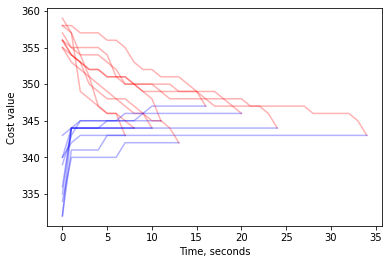

In [25]:
for upper, lower in zip(updata, ldata):
    plt.plot(upper, label='upper', alpha=0.3, color='r')
    plt.plot(lower, label='lower', alpha=0.3, color='b')
    
plt.xlabel('Time, seconds')
plt.ylabel('Cost value')

Text(0, 0.5, 'Cost value')

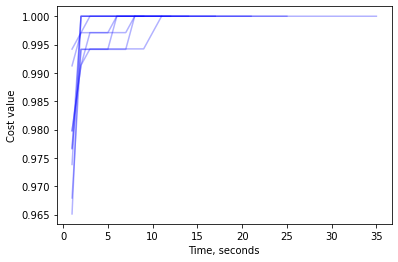

In [35]:
for upper, lower in zip(updata, ldata):
    upper = np.array(upper)
    lower = np.array(lower)
    x = range(1, len(lower)+1)
    #plt.plot(upper/upper.min(), label='upper', alpha=0.3, color='r')
    plt.plot(x, lower/lower.max(), label='lower', alpha=0.3, color='b')
    
plt.xlabel('Time, seconds')
plt.ylabel('Cost value')

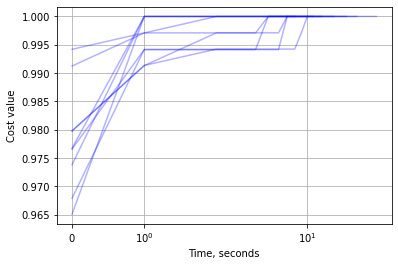

In [38]:
for upper, lower in zip(updata, ldata):
    upper = np.array(upper)
    lower = np.array(lower)
    x = range(0, len(lower))
    #plt.plot(upper/upper.min(), label='upper', alpha=0.3, color='r')
    plt.plot(x, lower/lower.max(), label='lower', alpha=0.3, color='b')
plt.xscale('symlog')    
plt.xlabel('Time, seconds')
plt.ylabel('Cost value')
plt.grid()

### Gurobi activate

In [36]:
import socket

if socket.gethostname() == 'DESKTOP-1OG5J92':
    gurobi_lic = '/home/plate/git-built/gurobi/'
    print('getting license')
    grbkey = '119a6834-b2ea-11eb-97fc-0242ac130002'
    # (over)write key to gurobi_lic directory and don't ask questions
    !grbgetkey -q --path $gurobi_lic $grbkey

getting license
info  : grbgetkey version 9.1.2, build v9.1.2rc0
info  : Contacting Gurobi license server...
info  : License file for license ID 631645 was successfully retrieved
info  : License expires at the end of the day on 2021-07-11
info  : Saving license file...
info  : License 631645 written to file /home/plate/git-built/gurobi/gurobi.lic


In [32]:
socket.gethostname()

'DESKTOP-1OG5J92'

## Old scripts by Tom

<ipython-input-37-714f786696c5>:94: RuntimeWarning: invalid value encountered in double_scalars
  cycles_per_load = np.maximum(1, np.floor((0.25*n_atoms - initialization_losses)/per_cycle_losses))
<ipython-input-37-714f786696c5>:116: RuntimeWarning: invalid value encountered in double_scalars
  cycles_per_load = np.maximum(1, np.floor((0.25*n_atoms - initialization_losses)/per_cycle_losses))
<ipython-input-37-714f786696c5>:116: RuntimeWarning: invalid value encountered in double_scalars
  cycles_per_load = np.maximum(1, np.floor((0.25*n_atoms - initialization_losses)/per_cycle_losses))


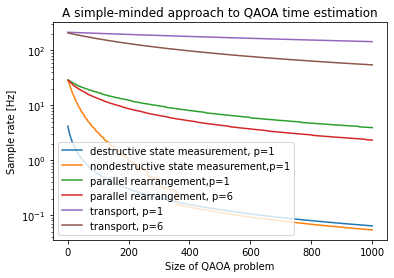

In [38]:
n_qaoa = np.linspace(1,1000,1000)
sr_qaoa1 = np.linspace(1,1000,1000)
for jj in np.arange(len(n_qaoa)):
    sr_qaoa1[jj] = sample_rate_destructive_sequential_really_simple(jj, 1, 3)
plt.plot(n_qaoa, sr_qaoa1)
sr_qaoa2 = np.linspace(1,1000,1000)
for jj in np.arange(len(n_qaoa)):
    sr_qaoa2[jj] = sample_rate_nondestructive_sequential_really_simple(jj, 1, 3)
plt.plot(n_qaoa, sr_qaoa2)
sr_qaoa3 = np.linspace(1,1000,1000)
for jj in np.arange(len(n_qaoa)):
    sr_qaoa3[jj] = sample_rate_nondestructive_parallel_really_simple(jj, 1, 3)
plt.plot(n_qaoa, sr_qaoa3)
sr_qaoa6 = np.linspace(1,1000,1000)
for jj in np.arange(len(n_qaoa)):
    sr_qaoa6[jj] = sample_rate_nondestructive_parallel_really_simple(jj, 6, 3)
plt.plot(n_qaoa, sr_qaoa6)
sr_qaoa4 = np.linspace(1,1000,1000)
for jj in np.arange(len(n_qaoa)):
    sr_qaoa4[jj] = sample_rate_transport_really_simple(jj, 1, 3)
plt.plot(n_qaoa, sr_qaoa4)
sr_qaoa5 = np.linspace(1,1000,1000)
for jj in np.arange(len(n_qaoa)):
    sr_qaoa5[jj] = sample_rate_transport_really_simple(jj, 6, 3)
plt.plot(n_qaoa, sr_qaoa5)




plt.yscale('log')

plt.xlabel('Size of QAOA problem')
plt.ylabel('Sample rate [Hz]')
plt.legend(['destructive state measurement, p=1','nondestructive state measurement,p=1', 'parallel rearrangement,p=1','parallel rearrangement, p=6','transport, p=1','transport, p=6'])
plt.title('A simple-minded approach to QAOA time estimation')
plt.savefig('simple_minded_qaoa_time_estimation.png')


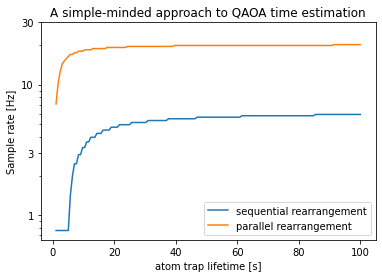

In [34]:
# look at the impact of changing background losses
# pin at N=66 (hilbert is n_atoms = 100 => n_nodes = 66 for d = 3, consider soon and later at p=1, d=3
# pin state measurement loss at 0.01

nondestructive_state_measurement_loss = 0.01
lifetimes = np.linspace(1,100,150)
srs_nondestructive_parallel = []
srs_nondestructive_sequential = []
for jj in np.arange(len(lifetimes)):
    atom_lifetime_short = lifetimes[jj]
    sr_jj_nd_s = sample_rate_nondestructive_sequential_really_simple(66, 1, 3)
    srs_nondestructive_sequential.append(sr_jj_nd_s)
    sr_jj_nd_p = sample_rate_nondestructive_parallel_really_simple(66, 1, 3)
    srs_nondestructive_parallel.append(sr_jj_nd_p)

plt.plot(lifetimes,srs_nondestructive_sequential)
plt.plot(lifetimes,srs_nondestructive_parallel)
plt.yscale('log')
plt.yticks([1,3,10,30],['1','3','10','30'])
plt.xlabel('atom trap lifetime [s]')
plt.ylabel('Sample rate [Hz]')
plt.legend(['sequential rearrangement','parallel rearrangement'])
plt.title('A simple-minded approach to QAOA time estimation')
plt.savefig('atom_lifetime_dependence.png')

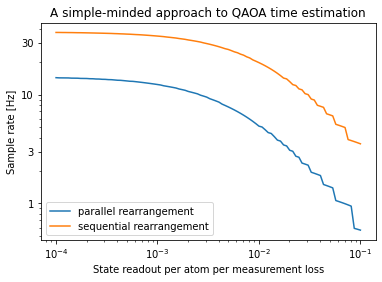

In [35]:
# look at the impact of changing state measurement losses
# pin at N=66 (hilbert is n_atoms = 100 => n_nodes = 66 for d = 3, consider soon and later at p=1, d=3
# pin atom lifetime at 30 s

atom_lifetime_short = 30
state_readout_losses = np.logspace(-4,-1,100)

srs_nondestructive_parallel = []
srs_nondestructive_sequential = []
for jj in np.arange(len(state_readout_losses)):
    nondestructive_state_measurement_loss = state_readout_losses[jj]
    sr_jj_nd_s = sample_rate_nondestructive_sequential_really_simple(66, 1, 3)
    srs_nondestructive_sequential.append(sr_jj_nd_s)
    sr_jj_nd_p = sample_rate_nondestructive_parallel_really_simple(66, 1, 3)
    srs_nondestructive_parallel.append(sr_jj_nd_p)

plt.plot(state_readout_losses,srs_nondestructive_sequential)
plt.plot(state_readout_losses,srs_nondestructive_parallel)
plt.yscale('log')
plt.xscale('log')
plt.yticks([1,3,10,30],['1','3','10','30'])
plt.xlabel('State readout per atom per measurement loss')
plt.ylabel('Sample rate [Hz]')
plt.legend(['parallel rearrangement','sequential rearrangement'])
plt.title('A simple-minded approach to QAOA time estimation')
plt.savefig('state_readout_loss_dependence.png')


overhead time is 1.21
0.0009800951485254839
0.0
0.052740999999999996
5.221357622864353e-05
number of cycles per load is 473995.0
18.959663266700453
18.960580952200377
